In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from pandas.plotting import scatter_matrix
import pickle

In [11]:
water_quality_df_1 = pd.read_csv("./data/water-quality-site1.csv")
water_quality_df_2 = pd.read_csv("./data/water-quality-site2.csv")
water_quality_df_3 = pd.read_csv("./data/water-quality-site3.csv")
water_quality_df_4 = pd.read_csv("./data/water-quality-site4.csv")

water_quality_columns_to_drop = []

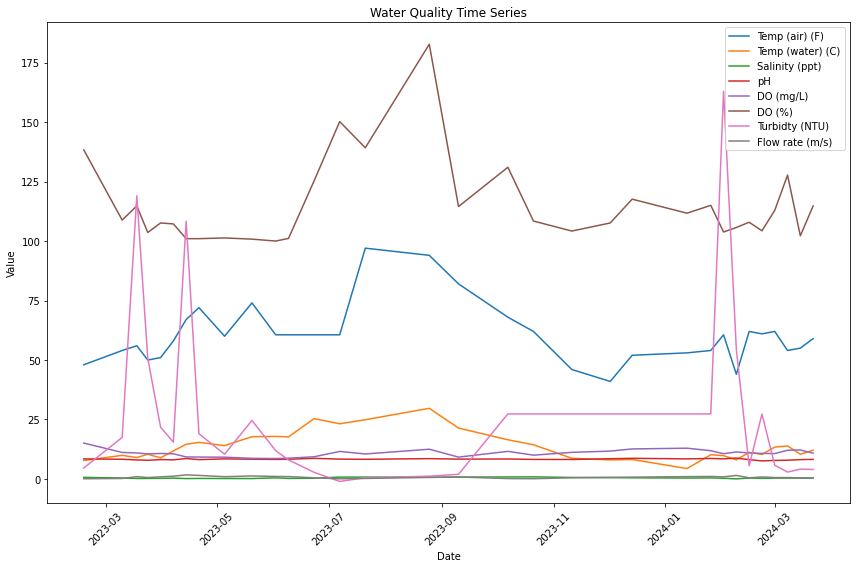

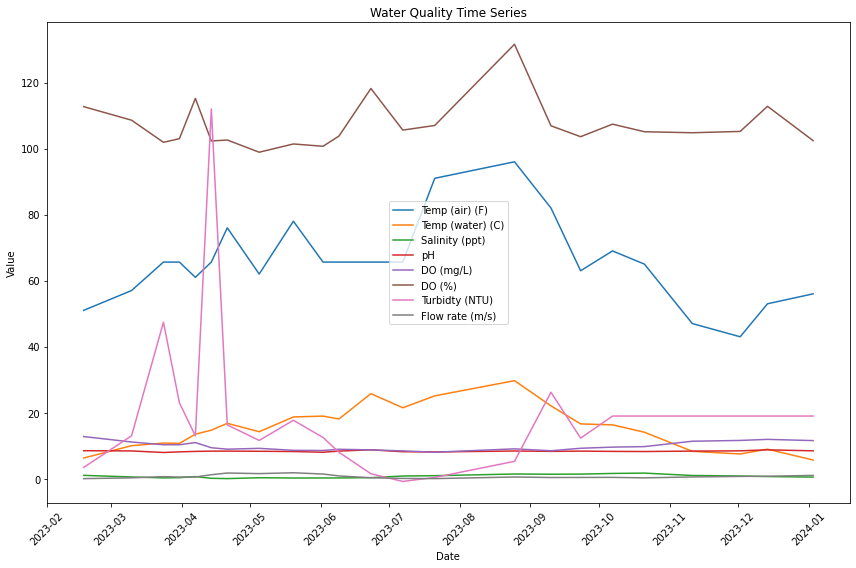

ValueError: unconverted data remains when parsing with format "%m/%d/%y": "23", at position 4. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [12]:
### CLEAN DATA BY FILLING EMPTY COLUMS WITH MEAN VALUE

def clean_data(df):
    # remove the first 8 columns
    df.columns = df.iloc[7]
    df = df.drop(index=[i for i in range(0,8)])

    # Clean notes column here
    if 'notes' in df.columns:
        df = df.drop("notes", axis=1)
    elif 'Notes' in df.columns:
        df = df.drop("Notes", axis=1)

    # Clean notes column here
    if 'Depth' in df.columns:
        df = df.drop("Depth", axis=1)
    elif 'Depth (cm)' in df.columns:
        df = df.drop("Depth (cm)", axis=1)

    # Clean DO-5 (mg/L) column here
    if 'DO-5 (mg/L)' in df.columns:
        df = df.drop("DO-5 (mg/L)", axis=1)

    # drop the last seven rows of averages
    df = df.iloc[:-7]

    return df

def fill_in_empty_cells_with_average(df, is_three=False):
    df = clean_data(df)

    if is_three:
        error_row = df.loc[df['Nitrate (mg/L)'] == 'error in test']
        if not error_row.empty:
            # Get the index of the row
            error_index = error_row.index[0]
            # Replace "error" with 0
            df.at[error_index, 'Nitrate (mg/L)'] = 0

    data_fields = ['Temp (air) (F)', 'Temp (water) (C)', 'Salinity (ppt)', 'pH', 'DO (mg/L)', 'DO (%)', 'Turbidty (NTU)', 'Flow rate (m/s)']

    for col in data_fields:
        df[col] = pd.to_numeric(df[col], errors='ignore')
        df[col].fillna(value=df[col].mean(), inplace=True)

    # Convert the 'Date' column to datetime format
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y')

    # Set the 'Date' column as the index of the DataFrame
    df.set_index('Date', inplace=True)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot each data field as a time series line
    for col in data_fields:
        ax.plot(df.index, df[col], label=col)

    # Set the x-axis label and rotate the tick labels
    ax.set_xlabel('Date')
    plt.xticks(rotation=45)

    # Set the y-axis label
    ax.set_ylabel('Value')

    # Add a legend
    ax.legend()

    # Add a title
    plt.title('Water Quality Time Series')

    # Display the graph
    plt.tight_layout()
    plt.show()

    return df

water_quality_df_1 = fill_in_empty_cells_with_average(water_quality_df_1)
water_quality_df_2 = fill_in_empty_cells_with_average(water_quality_df_2)
water_quality_df_3 = fill_in_empty_cells_with_average(water_quality_df_3, True)
water_quality_df_4 = fill_in_empty_cells_with_average(water_quality_df_4)

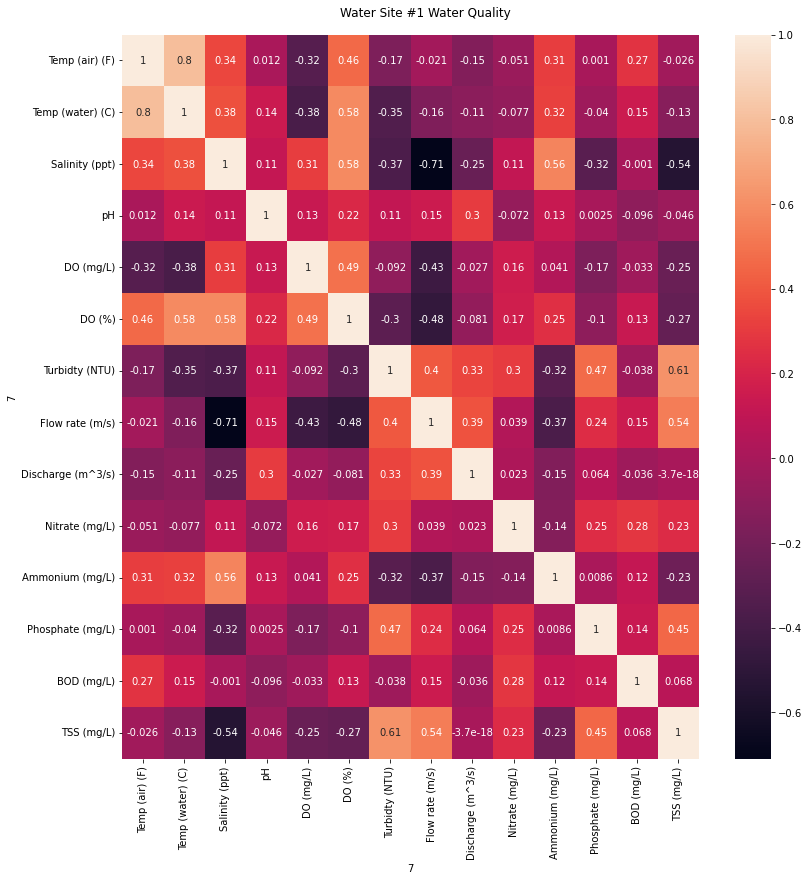

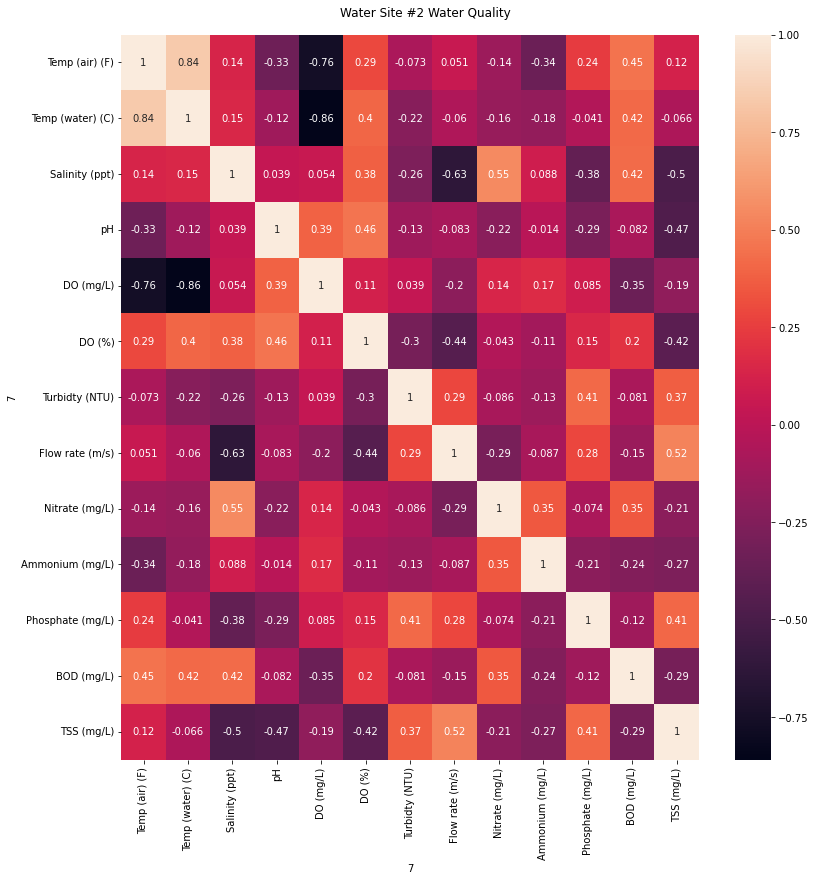

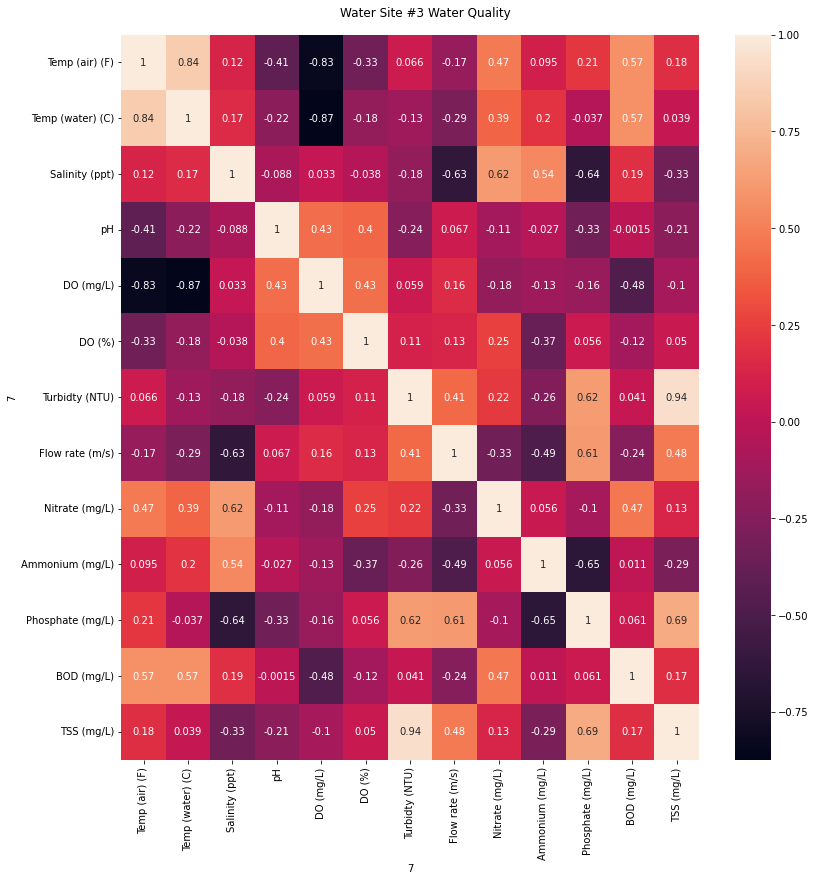

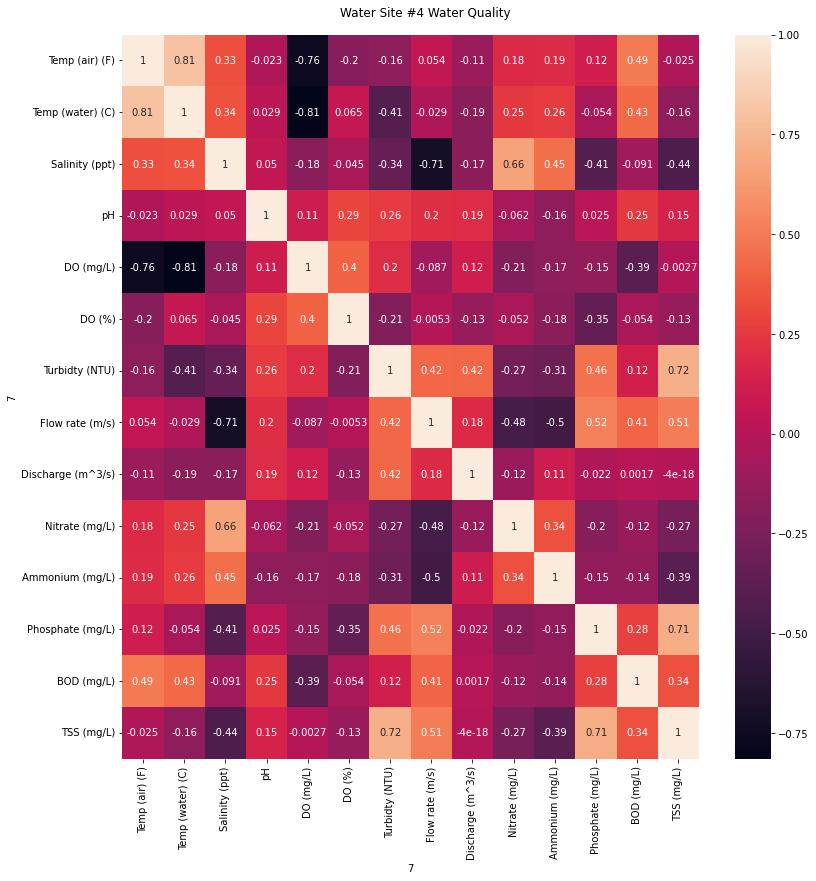

In [8]:
def make_correlation_matrix(dataframe, name, filename):
    corr_matrix = dataframe.corr()
    plt.subplots(figsize=(13,13))
    figure = sn.heatmap(corr_matrix, annot=True).get_figure()
    figure.tight_layout(pad=5.0)
    figure.suptitle(name)
    figure.subplots_adjust(top=0.95)
    figure.savefig(filename)
    corr_matrix = dataframe.corr()

make_correlation_matrix(water_quality_df_1, "Water Site #1 Water Quality",'water-site-1-cm.png')
make_correlation_matrix(water_quality_df_2, "Water Site #2 Water Quality",'water-site-2-cm.png')
make_correlation_matrix(water_quality_df_3, "Water Site #3 Water Quality",'water-site-3-cm.png')
make_correlation_matrix(water_quality_df_4, "Water Site #4 Water Quality",'water-site-4-cm.png')

In [5]:
### Make data for a model
"""

DO	0.17
FC	0.16
pH	0.11
BOD	0.11
Temperature	0.1
Nitrate	0.1
Total Phosphate	0.1
Turbitidy	0.08
Total Solids	0.07

Into by evenly distributing missing value

DO	0.19
pH	0.13
BOD	0.13
Temperature	0.12
Nitrate	0.12
Total Phosphate	0.12
Turbitidy	0.10
Total Solids	0.09

TS = TSS + TDS
"""
do = 0.19
ph = 0.13
bod = 0.13
temperature = 0.12
nitrate = 0.12
phosphate = 0.12
turbitidy = 0.10
ts = 0.09

W = np.array([do, ph, bod, temperature, nitrate, phosphate, turbitidy, ts])

column_var_map = {
    'DO (mg/L)': 'do',
    'pH': 'ph',
    'BOD (mg/L)': 'bod',
    'Temp (water) (C)': 'temperature',
    'Nitrate (mg/L)': 'nitrate',
    'Phosphate (mg/L)': 'phosphate',
    'Turbidty (NTU)': 'turbitidy',
    'TSS (mg/L)': 'ts'
}

def calculate_wqi(df):
    df['WQI'] = 0
    
    for col, var in column_var_map.items():
        if col in df.columns:
            print(col, W[np.where(W == globals()[var])[0][0]])
            df['WQI'] += df[col] * W[np.where(W == globals()[var])[0][0]]
    
    return df

water_quality_df_1 = calculate_wqi(water_quality_df_1)
water_quality_df_2 = calculate_wqi(water_quality_df_2)
water_quality_df_3 = calculate_wqi(water_quality_df_3)
water_quality_df_4 = calculate_wqi(water_quality_df_4)

pickle.dump(water_quality_df_1, open("water_quality_df_1.pkl",'wb'))
pickle.dump(water_quality_df_2, open("water_quality_df_2.pkl",'wb'))
pickle.dump(water_quality_df_3, open("water_quality_df_3.pkl",'wb'))
pickle.dump(water_quality_df_4, open("water_quality_df_4.pkl",'wb'))

DO (mg/L) 0.19
pH 0.13
BOD (mg/L) 0.13
Temp (water) (C) 0.12
Nitrate (mg/L) 0.12
Phosphate (mg/L) 0.12
Turbidty (NTU) 0.1
TSS (mg/L) 0.09
DO (mg/L) 0.19
pH 0.13
BOD (mg/L) 0.13
Temp (water) (C) 0.12
Nitrate (mg/L) 0.12
Phosphate (mg/L) 0.12
Turbidty (NTU) 0.1
TSS (mg/L) 0.09
DO (mg/L) 0.19
pH 0.13
BOD (mg/L) 0.13
Temp (water) (C) 0.12
Nitrate (mg/L) 0.12
Phosphate (mg/L) 0.12
Turbidty (NTU) 0.1
TSS (mg/L) 0.09
DO (mg/L) 0.19
pH 0.13
BOD (mg/L) 0.13
Temp (water) (C) 0.12
Nitrate (mg/L) 0.12
Phosphate (mg/L) 0.12
Turbidty (NTU) 0.1
TSS (mg/L) 0.09
